In [2]:
import os
import os.path
import shutil
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
def imshow(img):
    plt.imshow(img)
    plt.show()

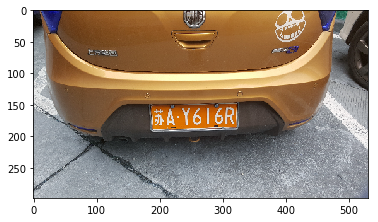

In [256]:
img=cv2.imread(PICFILE)
img=cv2.resize(img,(int(img.shape[1]/10),int(img.shape[0]/10)))
imshow(img)

(298, 531)


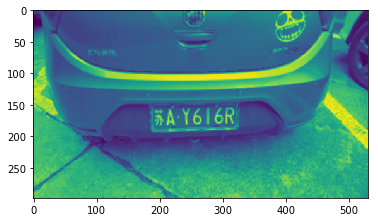

In [257]:
#高斯模糊20170221_141654
imggauss=cv2.GaussianBlur(img,(3,3),GaussianBlurSize)
#imshow(imggauss)
#cv2.imwrite('/home/wang/git/nppic/tt.jpg',imggauss)
#灰度化
imggray=cv2.cvtColor(imggauss,cv2.COLOR_BGR2GRAY)
print imggray.shape
imshow(imggray)

(298, 531)


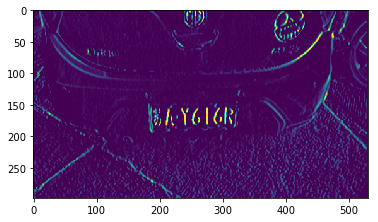

True

In [258]:
#Sobel运算  http://blog.csdn.net/sunny2038/article/details/9170013
#dst = cv2.Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]])  
#前四个是必须的参数：
#第一个参数是需要处理的图像；
#第二个参数是图像的深度，-1表示采用的是与原图像相同的深度。目标图像的深度必须大于等于原图像的深度；
#dx和dy表示的是求导的阶数，0表示这个方向上没有求导，一般为0、1、2。
#其后是可选的参数：
#dst不用解释了；
#ksize是Sobel算子的大小，必须为1、3、5、7。
#scale是缩放导数的比例常数，默认情况下没有伸缩系数；
#delta是一个可选的增量，将会加到最终的dst中，同样，默认情况下没有额外的值加到dst中；
#borderType是判断图像边界的模式。这个参数默认值为cv2.BORDER_DEFAULT

#常量SOBEL_X_WEIGHT与SOBEL_Y_WEIGHT代表水平方向和垂直方向的权值，
#              默认
imgsobel=cv2.Sobel(imggray,ddepth=-1,dx=1,dy=0,ksize=3)  #dxdy前者1后者0，代表仅做水平方向求导不做垂直方向求导
print imgsobel.shape
imshow(imgsobel)
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgsobel)

(298, 531)


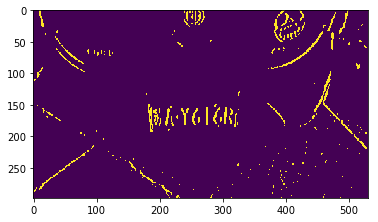

True

In [259]:
#二值化
_,imgthreshold  = cv2.threshold(imgsobel, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY) #二值化
print imgthreshold.shape
imshow(imgthreshold)
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgthreshold)

(298, 531)
(298, 531)


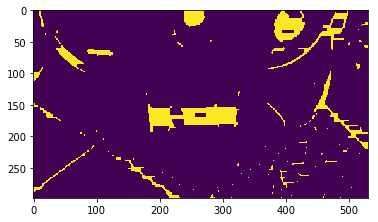

True

In [269]:
#闭操作
print imgthreshold.shape
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(17,5)) #(7,3)闭操作，先膨胀再腐蚀
imgclose=cv2.morphologyEx(imgthreshold, cv2.MORPH_CLOSE, kernel)
##eroded = cv2.erode(imgt,kernel)
#imclose = cv2.dilate(imgthreshold,kernel)
print imgclose.shape
imshow(imgclose)
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgclose)



In [270]:
#imger=imgclose.copy()
#eroded = cv2.erode(imger,kernel)
#imshow(eroded)

In [271]:
#imgdi = eroded.copy()
#dilated=cv2.dilate(imgdi,kernel)
#imshow(dilated)

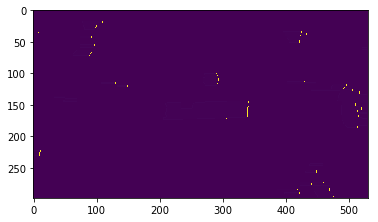

True

In [272]:
#求轮廓
imgcont=np.copy(dilated)
(contours,_) = cv2.findContours(imgcont,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#cv2.drawContours(imgcont,contours,-1,(0,0,255),2)
imshow(imgcont)
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgcont)
#imshow(imgclose)
#for c in contours:
#    if cv2.contourArea(c)

In [273]:
#对轮廓求最小外接矩形，然后验证，不满足条件的淘汰
imgc=imgclose
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
print len(con)
for i,c in enumerate(con):
    if len(c) < 4:
        continue
    x,y,w,h=cv2.boundingRect(c)
    #ratio=w//h
    #if ratio>8 or ratio < 4:
    #    continue
    if w< 40 or h < 15:
        continue
    ret.append((x,y,w,h))
    #rect=cv2.minAreaRect(c)
    #box = np.int0(cv2.cv.BoxPoints(rect))
    #cv2.drawContours(imgc,[box],-1, (0, 0, 255), 3)
#imshow(imgc)
#cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgc)
print len(ret)
#角度判断与旋转
#暂无

21
3


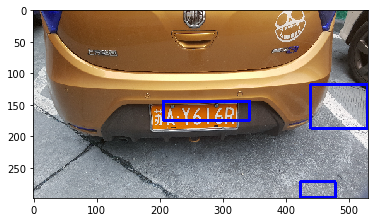

True

In [274]:
imgrect=img
for _,r in enumerate(ret):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),3)
imshow(imgrect)    
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgrect)

In [513]:
PICFILE='/home/wang/git/nppic/su_np_color/20170220_141344.jpg'
#ICFILE='/home/wang/git/nppic/su_np_color/20170220_141247.jpg'

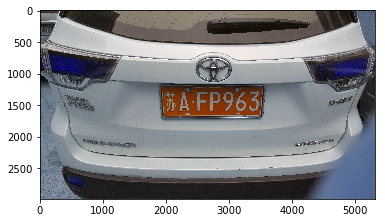

In [514]:
img = cv2.imread(PICFILE)
#img=cv2.resize(img,(int(img.shape[1]/10),int(img.shape[0]/10)))
imshow(img)

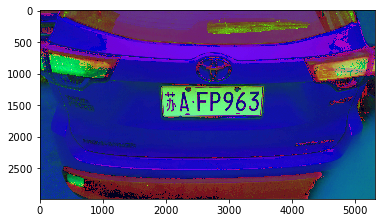

In [515]:
colorImage = img.copy()
_colorImage = img.copy()
hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
imshow(hsv)

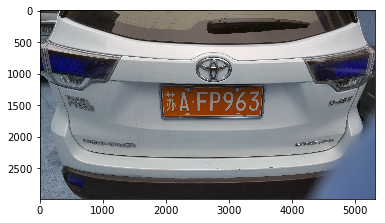

In [516]:
#高斯模糊
img = cv2.GaussianBlur(img,(5,5),0)
imshow(img)

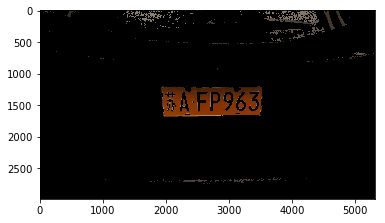

In [517]:
#阈值和掩模
lower=np.array([100,50,50])
upper=np.array([140,255,255])
mask=cv2.inRange(hsv,lower,upper)
res=cv2.bitwise_and(img,img,mask=mask)
imshow(res)

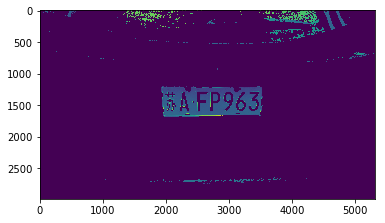

In [518]:
#灰度化
gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
imshow(gray)

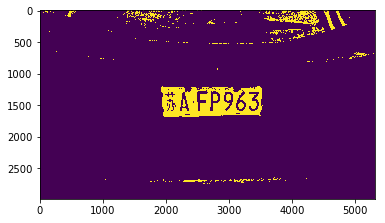

In [519]:
#二值化
ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(thresh)

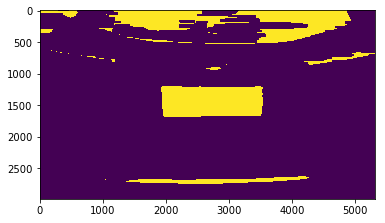

In [520]:
#闭操作
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(171, 31))
imgclose = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
imshow(imgclose)

In [521]:
#轮廓
(contours, _) = cv2.findContours(imgclose.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [522]:
#对轮廓求最小外接矩形，然后验证，不满足条件的淘汰
imgc=imgclose
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    ratio=w//h
    if ratio>5 or ratio < 2:
        continue
    if w< 400 or h < 150:
        continue
    ret.append((x,y,w,h))
print len(ret)
#角度判断与旋转
#暂无

2


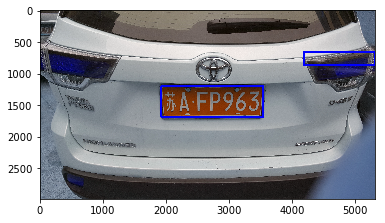

True

In [523]:
#绘制
imgrect = cv2.imread(PICFILE)
for i,r in enumerate(ret):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),30)
imshow(imgrect)    
cv2.imwrite('/home/wang/git/nppic/tt.jpg',imgrect)

/home/wang/git/nppic/0.jpg
/home/wang/git/nppic/100.jpg


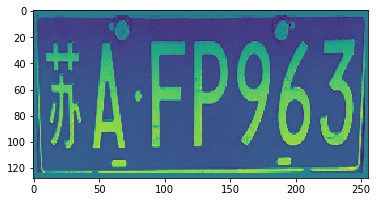

In [524]:
#截取
npjpg=[] #原图
detect=np.ndarray((len(ret),1,128,256),np.uint8) #检测的图
for i,(x,y,w,h) in enumerate(ret):
    imgr=imgrect[y:y+h,x:x+w]
    npjpg.append(imgr.copy())
    imgray=cv2.cvtColor(imgr,cv2.COLOR_BGR2GRAY)
    imgray=cv2.resize(imgray,(256,128))
    detect[i][0]=imgray
    fname='/home/wang/git/nppic/{}.jpg'.format(i*100)
    print fname
    cv2.imwrite(fname,imgr)
imshow(detect[0][0])

In [342]:
#model
conv=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,padding=1), #layer1, inputs single channel,256*128
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,padding=1), #layer2 inputs 64 channel,128*64
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=3,padding=1), #layer3 inputs 128 channel,64*32
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,512,kernel_size=3,padding=1), #layer4 inputs 256 channel,32*16
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512,512,kernel_size=3,padding=1), #layer5 inputs 512 channel,16*8
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
    )

class vgg16train(nn.Module):
    def __init__(self):
        super(vgg16train,self).__init__()
        self.features=conv
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 8 * 4, 4096),                             #connect: layter: inputs 512, 8*4
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 2)
        )
        #initialize_weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [351]:
#pytorch folder dataset 以目录区分类别时，类别和索引的映射
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [415]:
classes,class_to_idx=find_classes('/home/wang/git/nppic/nproot')
print class_to_idx
#{'plate': 1, 'back': 0}
npclass_to_idx={'plate': 1, 'back': 0}

{'plate': 1, 'back': 0}


In [343]:
model=vgg16train()
model.load_state_dict(torch.load('/home/wang/git/anpr/plate.0421.weight'))

AssertionError: (AssertionError('\nFound no NVIDIA driver on your system. Please check that you\nhave an NVIDIA GPU and installed a driver from\nhttp://www.nvidia.com/Download/index.aspx',), <class 'torch.cuda.FloatTensor'>, ())

In [315]:
#npjpg#原图
#detect#待检测的图
mean=69.4305729761
var=105.002518454
detect=(detect-mean)/var
datas=torch.FloeatTensor(detect)
data_var=Variable(datas)
output_var=model(data_var)
_, predicted = torch.max(outputs.data, 1)

AttributeError: 'list' object has no attribute 'shape'

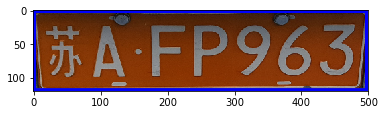

In [65]:
#字符切割
CHARFILE='/home/wang/git/nppic/0.jpg'
#CHARFILE='/home/wang/git/nppic/02N29.bmp'
charimg=cv2.imread(CHARFILE)
imgchar=cv2.resize(charimg,(500,120))
imshow(imgchar)

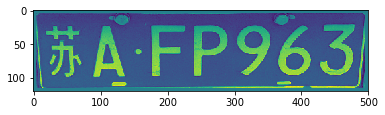

In [66]:
gray_img = cv2.cvtColor(imgchar.copy(),cv2.COLOR_BGR2GRAY)  #灰度
imshow(gray_img)

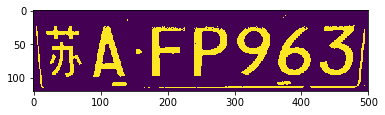

In [67]:
_,threshold_img  = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY) #二值化
imshow(threshold_img)

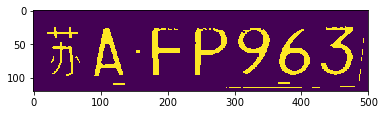

In [68]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3)) #闭操作，先膨胀再腐蚀
eroded = cv2.erode(threshold_img,kernel)
imshow(eroded)

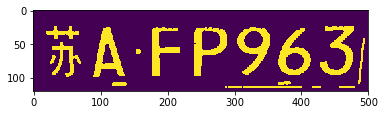

In [69]:
dilated = cv2.dilate(eroded,kernel)
imshow(dilated)

In [70]:
(contours,_) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
#w:500 h:124
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    ratio=w//h
    if w<30 or h < 60:
        continue
    ret.append((x,y,w,h))
print len(ret)

6


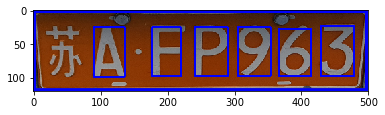

[(241, 25, 49, 73), (305, 25, 49, 72), (366, 27, 49, 70), (90, 25, 47, 74), (429, 23, 50, 74), (177, 25, 43, 73)]


In [71]:
#绘制
imgrect = imgchar.copy()
chars=sorted(ret)  ##根据x值进行排序
for i,r in enumerate(chars):
    x,y,w,h=r
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),2)
imshow(imgrect)    
print ret

In [72]:
#len(ret) == 6
chardatas=np.ndarray((len(chars),1,28,28),np.uint8)
imgcut=imgchar.copy()
for i,r in enumerate(chars):
    x,y,w,h=r
    chari=imgcut[y:y+h,x:x+w]  #切割
    chari=cv2.cvtColor(chari,cv2.COLOR_BGR2GRAY)  #灰度
    _,chari  = cv2.threshold(chari, 100, 255, cv2.THRESH_BINARY) #二值化
    chari=cv2.resize(chari.copy(),(28,28))    
    chardatas[i][0]=chari  #格式化20*20
    fname='/home/wang/git/nppic/char-{}.jpg'.format(i)
    cv2.imwrite(fname,chari)

In [73]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3,padding=1)   
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3,padding=1) 
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 100)
        self.fc2 = nn.Linear(100, 65)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))                                #20*20
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))   #10*10
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)   #28*28
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 65)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)        
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features    

In [74]:
#classes,class_to_idx=find_classes('/home/wang/git/nppic/ann/train')
#print class_to_idx
DIGITS='0123456789'
LETTER='ABCDEFGHJKLMNPQRSTUVWXYZ'
PROV='川鄂赣甘贵桂黑沪冀津京吉辽鲁蒙闽宁青琼陕苏晋皖湘新豫渝粤云藏浙'
CHAR=DIGITS+LETTER+PROV
CHARCLASSES=['0','1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z',
         'zh_cuan','zh_e','zh_gan','zh_gan1','zh_gui','zh_gui1','zh_hei','zh_hu','zh_ji','zh_jin','zh_jing','zh_jl','zh_liao','zh_lu','zh_meng',
        'zh_min','zh_ning','zh_qing','zh_qiong','zh_shan','zh_su','zh_sx','zh_wan','zh_xiang','zh_xin','zh_yu','zh_yu1','zh_yue','zh_yun',
        'zh_zang','zh_zhe']

In [75]:
model=Model()
#model=Net()
model.load_state_dict(torch.load('/home/wang/git/anpr/coder.model.weight'))
#model.load_state_dict(torch.load('/home/wang/git/anpr/coder.nn.weight'))

In [76]:
#chardatas.shape
mean=69.4305729761
var=105.002518454
chardatas=(chardatas-mean)/var

In [77]:
chardatas[0][0][0]

array([-0.66122769, -0.66122769, -0.66122769, -0.66122769, -0.66122769,
       -0.66122769, -0.66122769, -0.66122769, -0.66122769,  0.87206886,
        1.710144  ,  1.68157326,  1.76728549,  1.76728549,  1.76728549,
       -0.66122769, -0.66122769, -0.66122769, -0.66122769, -0.66122769,
       -0.66122769, -0.66122769, -0.66122769, -0.66122769, -0.66122769,
       -0.66122769, -0.66122769, -0.66122769])

In [63]:

charimgdata=torch.FloatTensor(chardatas)
outputs = model(Variable(charimgdata))
_, predicted = torch.max(outputs.data, 1)
predicted


  6
 15
 15
  9
  6
 21
[torch.LongTensor of size 6x1]

In [64]:
pred=predicted.numpy()
for i,c in enumerate(pred):
    idx=int(c[0])
    print CHARCLASSES[idx]

6
E
E
9
6
L
